In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling2D,Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import regularizers
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Input
import itertools
import collections
import os
import shutil
import random
import glob
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [13]:
#!unzip leaf-diseases.zip

In [4]:
# train,valid and test images new path
train_path = './leaf-diseases/train'
valid_path = './leaf-diseases/valid'

In [ ]:
train_num = sum(len(files) for _, _, files in os.walk(train_path))
print(train_num)

valid_num = sum(len(files) for _, _, files in os.walk(valid_path))
print(valid_num)

9191
1625


In [5]:
IMG_SHAPE  = 380
BATCH_SIZE = 32

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=45,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest')    
      

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_path,
                                                     shuffle = True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='categorical')


image_gen_valid = ImageDataGenerator( rescale=1./255)

valid_data_gen = image_gen_valid.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=valid_path,
                                                     shuffle = False,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='categorical')

Found 9191 images belonging to 5 classes.
Found 1625 images belonging to 5 classes.


In [ ]:
# fun to plot images

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

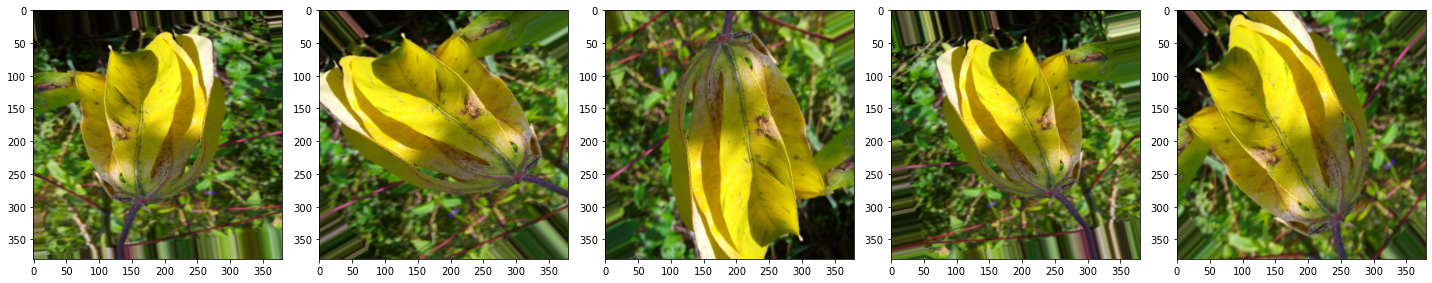

In [ ]:
# plot an augmented sample
augmented_images = [train_data_gen[0][0][1] for i in range(5)]
plotImages(augmented_images)

In [ ]:
input_t = tf.keras.Input(shape=(380, 380, 3))
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor = input_t )
    
model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(8, bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001), activation='relu'),
tf.keras.layers.BatchNormalization(renorm=True),
tf.keras.layers.Dense(5, activation='softmax')])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 12, 12, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 16392     
_________________________________________________________________
batch_normalization_10 (Batc (None, 8)                 56        
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 45        
Total params: 23,604,205
Trainable params: 23,551,045
Non-trainable params: 53,160
_________________________________________________________________


In [ ]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=10000, decay_rate=0.9)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history = model.fit(train_data_gen,
                    validation_data = valid_data_gen,
                    epochs= 15,batch_size = 32,
                    steps_per_epoch = train_num // BATCH_SIZE + 1,
                    validation_steps= valid_num // BATCH_SIZE + 1)
    
model.save('leaf-disease7'+'.h5')  

Epoch 1/15
288/288 [==============================] - 450s 2s/step - loss: 1.5839 - categorical_accuracy: 0.3237 - val_loss: 12.1659 - val_categorical_accuracy: 0.2025
Epoch 2/15
288/288 [==============================] - 441s 2s/step - loss: 1.1265 - categorical_accuracy: 0.5766 - val_loss: 2.2784 - val_categorical_accuracy: 0.2302
Epoch 3/15
288/288 [==============================] - 449s 2s/step - loss: 0.9677 - categorical_accuracy: 0.6561 - val_loss: 2.4911 - val_categorical_accuracy: 0.3132
Epoch 4/15
288/288 [==============================] - 462s 2s/step - loss: 0.8732 - categorical_accuracy: 0.7020 - val_loss: 0.9469 - val_categorical_accuracy: 0.6634
Epoch 5/15
288/288 [==============================] - 460s 2s/step - loss: 0.8223 - categorical_accuracy: 0.7230 - val_loss: 0.8666 - val_categorical_accuracy: 0.7065
Epoch 6/15
288/288 [==============================] - 462s 2s/step - loss: 0.8083 - categorical_accuracy: 0.7345 - val_loss: 0.8399 - val_categorical_accuracy: 0.71

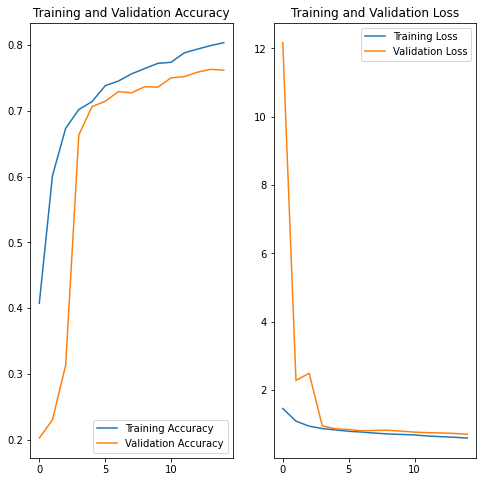

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [6]:
new_model = load_model('./leaf-disease7.h5')

In [10]:
pred = new_model.predict(valid_data_gen) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

# Obtain actual labels
actual = valid_data_gen.classes

In [11]:
print(classification_report(actual,pred))

              precision    recall  f1-score   support

           0       0.34      0.60      0.43       164
           1       0.87      0.69      0.77       329
           2       0.92      0.66      0.77       358
           3       0.87      0.85      0.86       387
           4       0.68      0.77      0.72       387

    accuracy                           0.73      1625
   macro avg       0.74      0.71      0.71      1625
weighted avg       0.78      0.73      0.74      1625



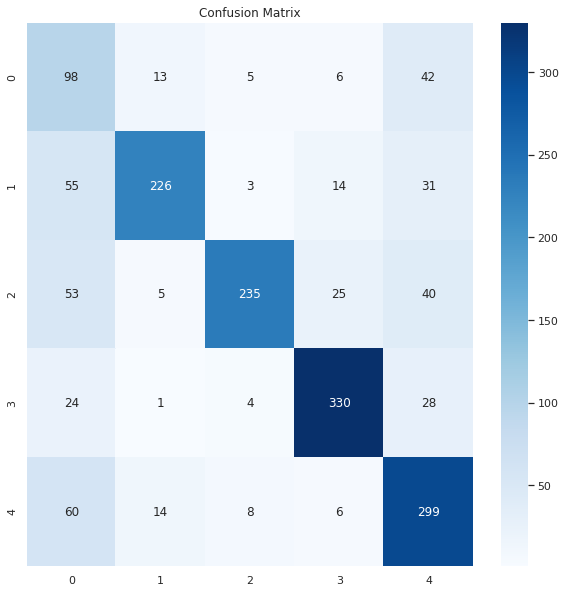

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
    
# Now plot matrix
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style('whitegrid')
cm = confusion_matrix(actual, pred, labels = [0,1,2,3,4])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.title("Confusion Matrix", fontsize=12)
plt.show()